In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('../dataset/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] # crop the first latter and append the one ahead
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [9]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [2]:
g = torch.Generator().manual_seed(2147483647) # To generate same random numbers everytime

In [4]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [27]:
n_embed = 10 # dimensionaltiy of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of MLP
vocab_size = 27
block_size = 3

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

47024


In [28]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 # if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2729
  10000/ 200000: 2.6800
  20000/ 200000: 2.2952
  30000/ 200000: 2.0213
  40000/ 200000: 2.7483
  50000/ 200000: 1.9984
  60000/ 200000: 1.9489
  70000/ 200000: 2.4065
  80000/ 200000: 1.9094
  90000/ 200000: 2.1041
 100000/ 200000: 1.9536
 110000/ 200000: 1.7527
 120000/ 200000: 2.3175
 130000/ 200000: 1.8531
 140000/ 200000: 2.3584
 150000/ 200000: 1.8247
 160000/ 200000: 2.5672
 170000/ 200000: 2.2677
 180000/ 200000: 2.0958
 190000/ 200000: 1.9286


layer 2 (      Tanh): mean -0.01, std 0.73, saturated: 19.53%
layer 5 (      Tanh): mean +0.01, std 0.77, saturated: 21.50%
layer 8 (      Tanh): mean -0.02, std 0.79, saturated: 23.94%
layer 11 (      Tanh): mean -0.02, std 0.80, saturated: 25.16%
layer 14 (      Tanh): mean -0.00, std 0.80, saturated: 27.09%


Text(0.5, 1.0, 'activation distribution')

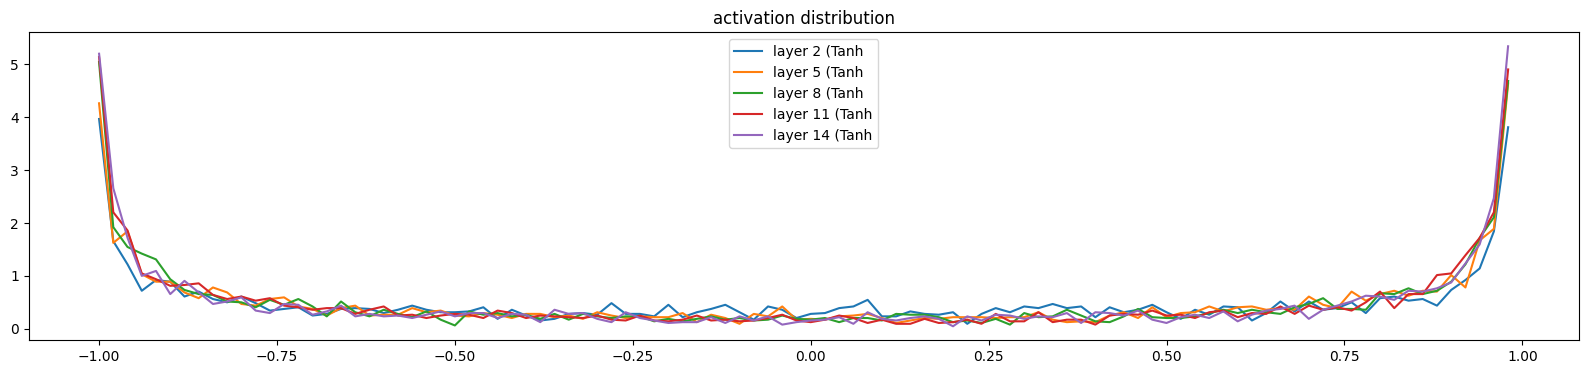

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.599196e-03
layer 5 (      Tanh): mean -0.000000, std 2.647584e-03
layer 8 (      Tanh): mean +0.000000, std 2.844215e-03
layer 11 (      Tanh): mean +0.000000, std 2.829191e-03
layer 14 (      Tanh): mean +0.000000, std 3.170641e-03


Text(0.5, 1.0, 'gradient distribution')

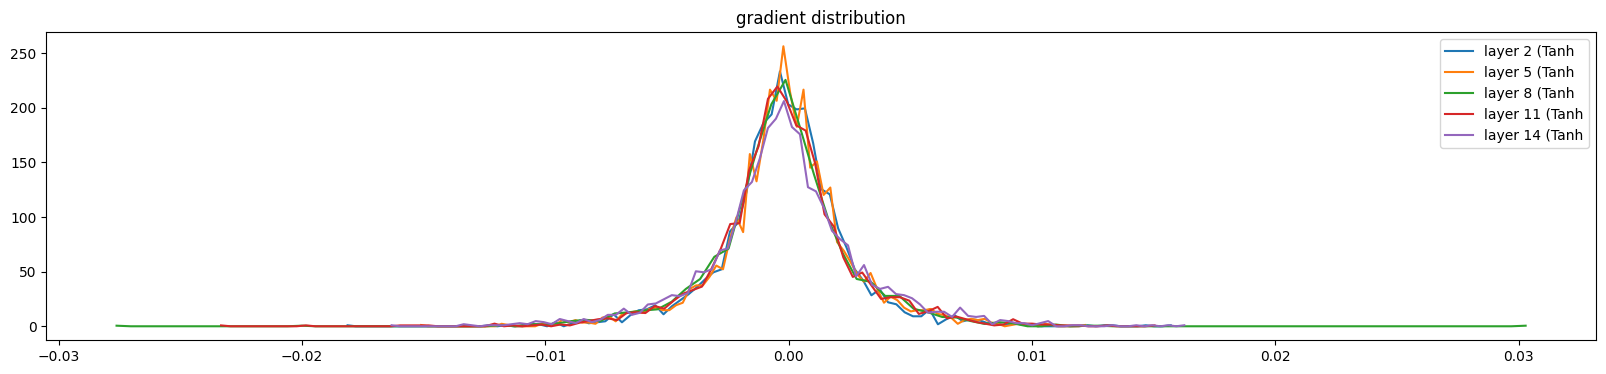

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.113127e-02 | grad:data ratio 9.386064e-03
weight  (30, 100) | mean -0.000003 | std 5.617111e-03 | grad:data ratio 1.268556e-02
weight (100, 100) | mean +0.000011 | std 3.616551e-03 | grad:data ratio 1.341227e-02
weight (100, 100) | mean +0.000058 | std 3.830770e-03 | grad:data ratio 1.435376e-02
weight (100, 100) | mean -0.000008 | std 3.897809e-03 | grad:data ratio 1.535117e-02
weight (100, 100) | mean +0.000022 | std 3.838952e-03 | grad:data ratio 1.619754e-02
weight  (100, 27) | mean +0.000028 | std 6.258104e-03 | grad:data ratio 1.618670e-02


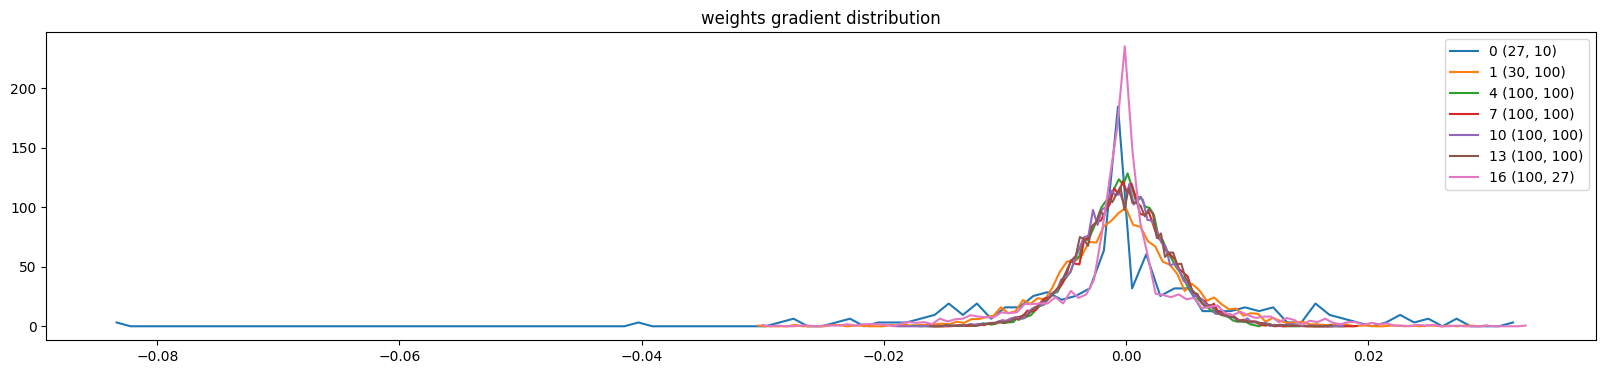

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

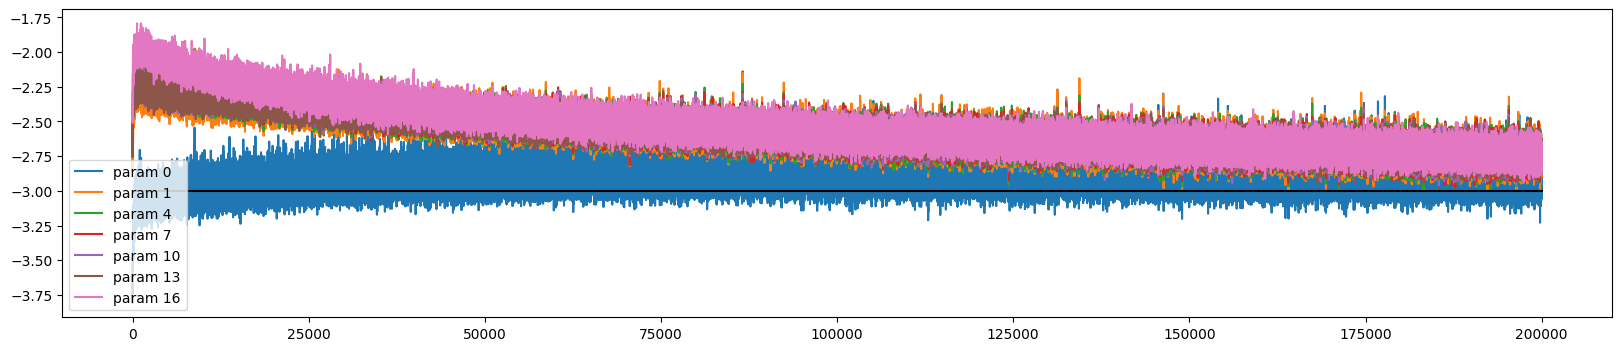

In [32]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False

split_loss('train')
split_loss('val')

train 2.0223276615142822
val 2.097731113433838


In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelle.
khyrilli.
tatyanna.
sane.
mahnee.
delynn.
jareei.
ner.
kiah.
maiiv.
kaleigh.
ham.
jorn.
quintis.
lilea.
jadiquinte.
madearistin.
jenni.
sabee.
